# Problem Set 1

In [1]:
import jax
import jax.numpy as np
import jax.lax as lax
import jax.scipy.stats as stats

In [2]:
import tools.models as mod
import tools.assign as ps

In [3]:
# configure matplotlib output
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
%matplotlib inline

In [4]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

### Setup

Check out `assign.py`, most of the implementation is hiding in there. We're just summarizing the results here. Note that `assign.py` uses some functions from `valjax`, so you'll have to have that in your Python path. Below are the parameters we'll be using. I didn't specify what to use for $\mu$, $\sigma$, and $\kappa$, but these make it so the entry distribution is well below the steady state and firms exit enough that we don't just get everyone bunched at the steady state capital level.

In [5]:
# model parameters
par = {
    'β': 0.95,
    'δ': 0.1,
    'α': 0.35,
    'z': 1.0,
    'μ': 0.5,
    'σ': 0.2,
    'κ': 0.1,
}

In [6]:
# algo params
N = 1000 # capital grid size
K = 400 # number of iterations

# Question 1

Here we look at two approaches. The first is brute force grid optimization. The second is basically the same, but we also get a better estimate of the true optimum by looking at the points around the max using `valjax.smoothmax`.

There's a third way where we actually use gradients of the interpolated continuation value to optimize the policy function. This ends up being kind of similar to a reinforcement learning approach. However, I'm having some trouble with numerical stability with that, so I'll just focus on the first two.

In [7]:
def value_summary(vfi, ret, hist):
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 3))
    ax0.plot(vfi.k_grid, ret['v']);
    ax1.plot(vfi.k_grid, ret['kp']-vfi.k_grid);
    ax1.scatter(vfi.kss, 0, c='k', zorder=10);
    ax1.hlines(0, *ax1.get_xlim(), color='k', linestyle='--', linewidth=1);
    pd.Series(hist['err']).plot(ax=ax2, logy=True)

### Grid

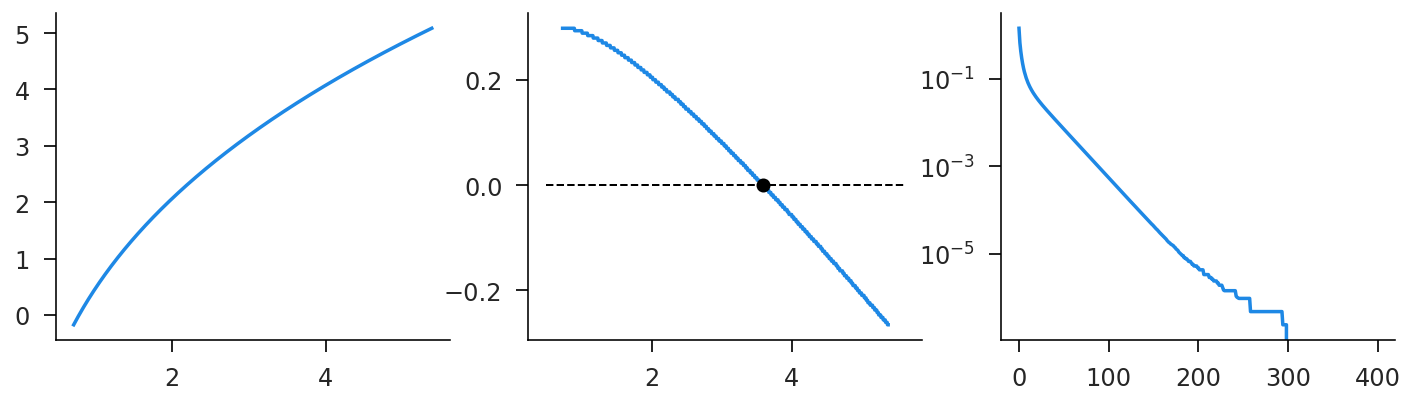

In [8]:
vfi_grid = ps.Capital(par, N=N)
v_grid, ret_grid, hist_grid = vfi_grid.fast_bellman(K=K)
value_summary(vfi_grid, ret_grid, hist_grid)

### Interp

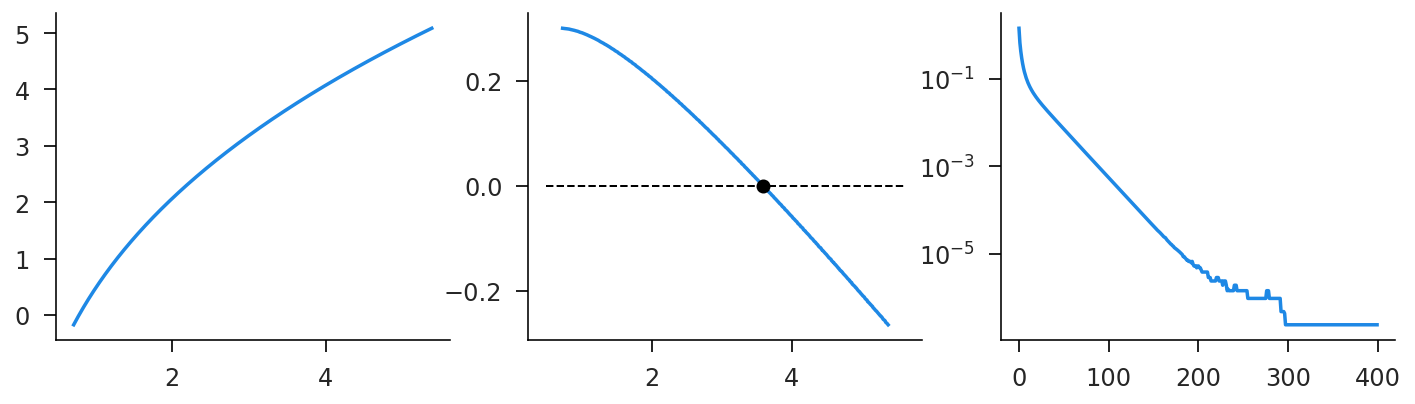

In [9]:
vfi_int = ps.Capital(par, interp=True, N=N)
v_int, ret_int, hist_int = vfi_int.fast_bellman(K=K)
value_summary(vfi_int, ret_int, hist_int)

### Compare

The timing comes out extremely similar, which isn't surprising since they are largely doing the same computations. There appears to be a slight loss of terminal accuracy in the interpolated case.

In [10]:
%time _ = vfi_grid.fast_bellman(K=K)

CPU times: user 587 ms, sys: 23.5 ms, total: 610 ms
Wall time: 566 ms


In [11]:
%time _ = vfi_int.fast_bellman(K=K)

CPU times: user 584 ms, sys: 44 ms, total: 628 ms
Wall time: 563 ms


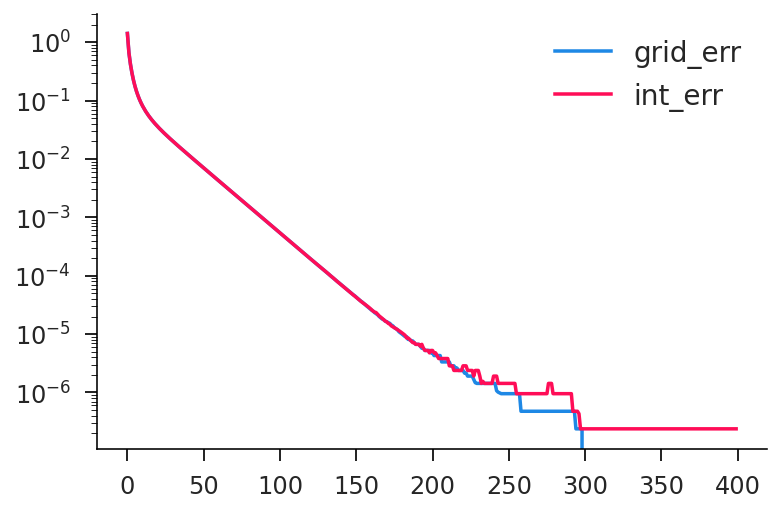

In [12]:
df_err = pd.DataFrame({
    'grid_err': hist_grid['err'],
    'int_err': hist_int['err'],
})
df_err.plot(logy=True);

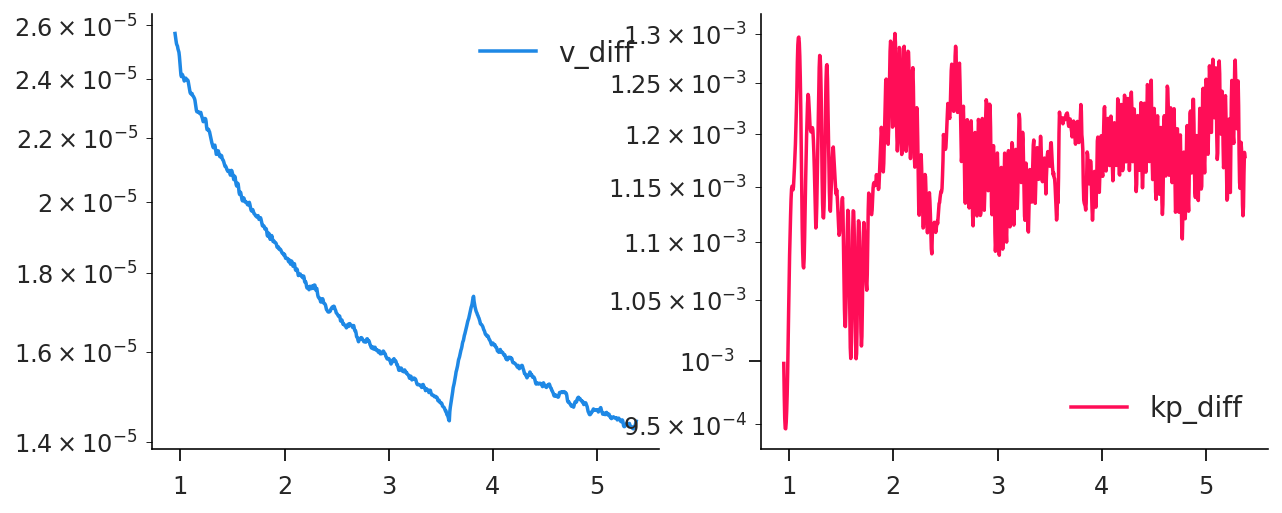

In [13]:
df_diff = pd.DataFrame({
    'v_diff': np.abs(v_grid-v_int),
    'kp_diff': np.abs(ret_grid['kp']-ret_int['kp']),
}, index=vfi_grid.k_grid)
df_diff.rolling(50).mean().plot(
    logy=True, subplots=True, layout=(1, 2), figsize=(10, 4)
);

# Question 2

Here because of the values for $\mu$ and $\sigma$, the distribution reflects entry at lower capital levels and the movement towards steady state for surviving firms. Both approaches yield the same result. But there is seemingly numerical noise that enters into the steady state distribution. I suspect that adding in some additional noise to capital levels would eliminate this.

In [14]:
def dist_summary(vfi, dist, ax, iss=None):
    iss = iss or np.argmax(dist)
    ax.plot(vfi.k_grid[:iss], dist[:iss])

In [15]:
k_dist_null = vfi_int.fast_distribution(ret_int['kp'], method='null')
k_dist_age = vfi_int.fast_distribution(ret_int['kp'], method='age')

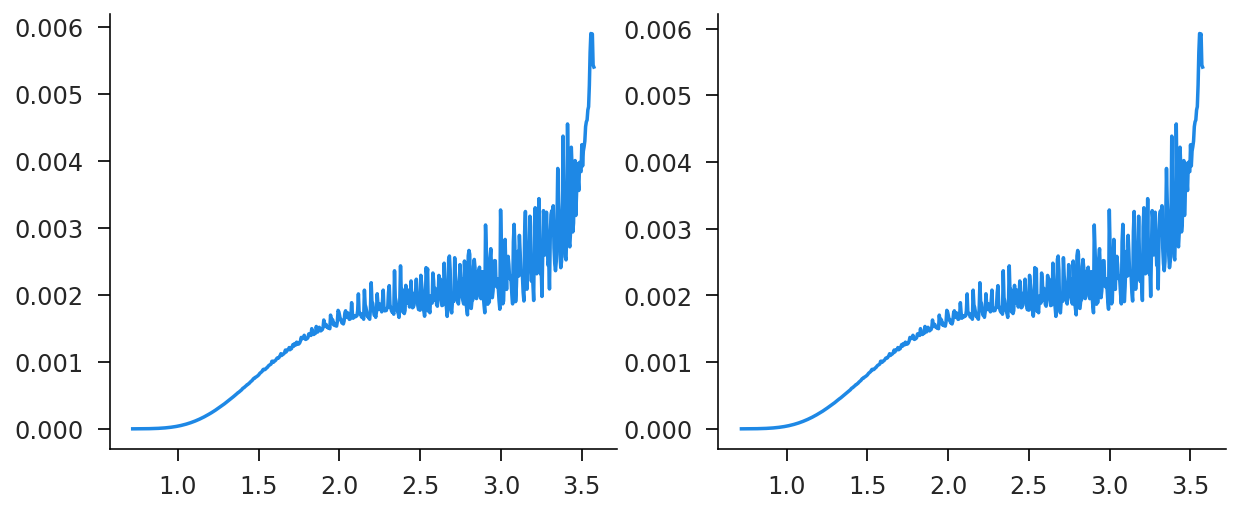

In [16]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
dist_summary(vfi_int, k_dist_null, ax0)
dist_summary(vfi_int, k_dist_age, ax1);

### Correcting Instability

You can see there there are some distributional "oscillations" showing up in the previous figure. This is due to the fact that slight numerical errors get propagated as firms age. Slight imperfections in the policy function get magnified as we move up the distribution. This arises partially because firms are essentially only moving up. By adding in a bit of random Gaussian noise, we can correct this.

In [17]:
par1 = {'γ': 0.05, **par}
vfi_fix = ps.Capital(par1, interp=True, N=N)
k_fix_null = vfi_fix.fast_distribution(ret_int['kp'], method='null')
k_fix_age = vfi_fix.fast_distribution(ret_int['kp'], method='age')

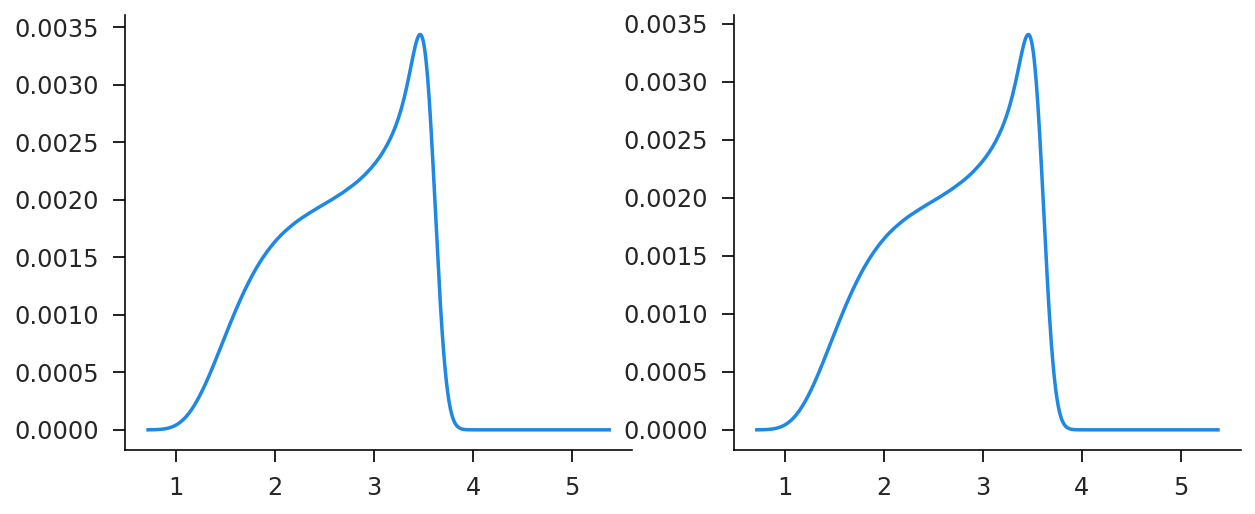

In [18]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.plot(vfi_fix.k_grid, k_fix_null)
ax1.plot(vfi_fix.k_grid, k_fix_age);